### Домашнее задание к вебинару 7

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

# для обработки текста
from string import punctuation
from stop_words import get_stop_words

import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# для сети
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchmetrics

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Загрузка данных

In [2]:
train_path = '../input/twitter-sentiment-analysis-hatred-speech/train.csv'
test_path = '../input/twitter-sentiment-analysis-hatred-speech/test.csv'

data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [3]:
data_train.head(3)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty


In [4]:
data_test.head(3)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...


In [5]:
data_train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

Есть выраженный дисбаланс

In [6]:
data_train.loc[data_train.label == 1, 'tweet'].tail(10)

31912    i couldn't end #2016 without mentioning #trump...
31926    a follow up from the gentlemen who were kicked...
31929    did  keep #colinpowell and #condoleezzarice fr...
31930    @user #feminismiscancer #feminismisterrorism #...
31933    @user judd is a  &amp; #homophobic #freemilo #...
31934    lady banned from kentucky mall. @user  #jcpenn...
31946    @user omfg i'm offended! i'm a  mailbox and i'...
31947    @user @user you don't have the balls to hashta...
31948     makes you ask yourself, who am i? then am i a...
31960    @user #sikh #temple vandalised in in #calgary,...
Name: tweet, dtype: object

In [7]:
data_train.loc[data_train.label == 0, 'tweet'].head(5)

0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: tweet, dtype: object

Класс 0 - твит является положительным, класс 1 - твит негативный, расистский. Твиты на английском языке, что важно учесть в будущей обработке.

In [8]:
# Разделим тренировочные данные на тренировочную и валидационную выборки

data_train, data_val = train_test_split(data_train, test_size = 0.3, random_state = 1)

data_train.label.value_counts(), data_val.label.value_counts()

(0    20780
 1     1593
 Name: label, dtype: int64,
 0    8940
 1     649
 Name: label, dtype: int64)

In [9]:
data_train[data_train.label == 1]

,id,label,tweet
24201,24202,1,â¦ you #hispanic &amp; feel like the are sto...
14444,14445,1,@user research: and played greatest role in ...
17857,17858,1,thought factory: left-right polarisation! #tru...
16680,16681,1,#italians weren't coming from a country were w...
20501,20502,1,"ending 2016 smoking reefers, going crazy, and ..."
...,...,...,...
17137,17138,1,pay porn free video jokes about women
31228,31229,1,ððð reading list for the new year: ...
16332,16333,1,@user a giant version of the #flag of #rebelli...
21440,21441,1,scapelliti: woobietuesday: when you're blocke...


In [10]:
disbalance_coeff = len(data_train[data_train.label == 0])/ len(data_train[data_train.label == 1])
disbalance_coeff

13.044569993722536

Дисбаланс довольно большой. Если сделать оверсэмплинг для меньшего класса, то может быть переобучение.

In [11]:
# Попробуем избавиться от дисбаланса классов на тренировочной выборке, дисбаланс слишком выражен
def oversampling_by_target(df, target_name):
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    # установим вручную коэффициент дисбаланса
    disbalance_coeff = 5
    
    for i in range(disbalance_coeff):
        # отсэмлируем меньшую выборку в количестве = disbalance_coeff
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [12]:
# data_train = oversampling_by_target(data_train, 'label')
# data_train.label.value_counts()

В этой задаче балансировка классов ухудшила результат.

#### Обработка твитов

In [13]:
max_words = 2000
max_len = 20
num_classes = 1

# для обучения
epochs = 10
batch_size = 128
print_batch_n = 100

In [14]:
# Загрузим стоп - слова
sw1 = get_stop_words('english')
sw2 = stopwords.words('english')

sw_all = set(sw1+sw2)

In [15]:
# Загрузим пунктуацию
puncts = set(punctuation)

In [16]:
# Лемматизация
# pymorphy не работает с английским языком, поэтому берем WordNetLemmatizer из nltk

lemmatizer = WordNetLemmatizer()

#пример 
lemmatizer.lemmatize('cities'), lemmatizer.lemmatize('children'), lemmatizer.lemmatize('walking')

('city', 'child', 'walking')

In [17]:
def preprocess_text(txt):
    # переводчим в строковый тип
    txt = str(txt)
    
    # убираем пунктауицию
    txt = "".join(c for c in txt if c not in puncts)
    
    # переводим в нижний регистр
    txt = txt.lower()
     
    # лемматизация и отсеивание стоп слов
    txt = [lemmatizer.lemmatize(word) for word in txt.split() if word not in sw_all]
    return " ".join(txt)

In [18]:
print(f"{data_train['tweet'].iloc[3]} --> {preprocess_text(data_train['tweet'].iloc[3])}")

@user @user @user @user @user @user   i'm always bereft when i finish something like that   --> user user user user user user im always bereft finish something like


In [19]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

data_train['tweet'] = data_train['tweet'].progress_apply(preprocess_text)
data_val['tweet'] = data_val['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:00<00:00, 18034.74it/s]


In [20]:
data_train.tweet

18168    russian default position faced accusation dopi...
15286    user user u looked one hairline already receiv...
4964     wowfinally see user southcitymall felling wait...
5373     user user user user user user im always bereft...
24201    â¦ hispanic amp feel like stomping listen ret...
                               ...                        
17289    remember itð lost empire dream success goal...
5192                             justice served bosmatrial
12172    ive repurposed former mustard jar beaut little...
235      happiest baby ive ever knownð cute smile ba...
29733         ased bull dominate bull direct whatever want
Name: tweet, Length: 22373, dtype: object

In [21]:
# делаем единый список слов из всех слов во всех строках

train_corpus = " ".join(data_train["tweet"])
train_corpus = train_corpus.lower()
len(train_corpus)

1362914

In [22]:
# Токенизация
tokens = word_tokenize(train_corpus) #на выходе будет лист токенов
tokens[:5]

['russian', 'default', 'position', 'faced', 'accusation']

In [23]:
# Сделаем фильтрацию токенов и отберем N самых часто встречающихся

# Отфильтруем те токены, которые не являются словами (буквами) или цифрами
tokens_filtered = [word for word in tokens if word.isalnum()]

In [24]:
# Сделаем словарь {слово: частота появления},
# Вывод будет отсортирован в порядке убывания популярности слова 

dist = FreqDist(tokens_filtered)
dist

FreqDist({'user': 12199, 'love': 1888, 'day': 1868, 'happy': 1181, 'u': 1135, 'amp': 1100, 'time': 868, 'life': 834, 'im': 780, 'today': 760, ...})

In [25]:
# Отберем первые N наиболее популярных токенов с паддингом = 1, 
# чтобы в будущем использовать 0 в качестве пустого значения

tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user', 'love', 'day', 'happy', 'u', 'amp', 'time', 'life', 'im', 'today'])

In [26]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()} # Начало индексов с 1 (не с 0)

# Самое частовстречающееся слово - user,проверим его индекс, должен быть = 1
vocabulary['user']

1

In [27]:
# Обернем преобразование твитов в последовательность

def text_to_sequence(tweet, maxlen):
    result = []
    #токенизация
    tokens = word_tokenize(tweet.lower())
    
    #отфильтровываем все, что не слова (буквы) и числа
    tokens_filtered = [word for word in tokens if word.isalnum()]
    
    for word in tokens_filtered:
        # добавляем в result только слова из vocabulary (топ 2000)
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [28]:
%%time
X_train = np.asarray([text_to_sequence(tweet, max_len) for tweet in data_train["tweet"]])
X_val = np.asarray([text_to_sequence(tweet, max_len) for tweet in data_val["tweet"]])
X_test = np.asarray([text_to_sequence(tweet, max_len) for tweet in data_test["tweet"]])

CPU times: user 7.73 s, sys: 10.6 ms, total: 7.74 s
Wall time: 7.74 s


In [29]:
data_train['tweet'].iloc[8], X_train[8]

('euphorix today 40 bottle stock get euphorix limited supply last user liquidhappieness positive energy',
 array([  10, 1360, 1297,   13,   81,    1,   15,  803,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]))

#### Создание datasets и dataloaders

In [30]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() # сразу переводим в тензор
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [31]:
#создание представителей классов Dataset и Dataloader
train_dataset = DataWrapper(X_train, data_train['label'].values)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(X_val, data_val['label'].values)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [32]:
# Проверка работы dataloader-a

for x, l in train_dataloader:
    print('Тренировочный датасет:\n')
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

print()
for x, l in val_dataloader:
    print('Валидационный датасет:\n')
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

Тренировочный датасет:

torch.Size([128, 20])
torch.Size([128])
tensor(0)

Валидационный датасет:

torch.Size([8, 20])
torch.Size([8])
tensor(0)


#### Построение нейронной сети
#### 1. LSTM

In [33]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=20, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        # print(x.shape)
        
        lstm_out, ht = self.gru(x)
        # lstm_out: тензор с выходными фичами с последнего слоя для каждого токена B, L, Hout
        # h_t: тензор с последними скрытыми состояниями по слоям (num_layers, B, Hout)
        # print(lstm_out.shape)
        # print(ht[1].shape)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
            # print(last_tensor.shape)
        else: # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
            # print(last_tensor.shape)
     
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lstm_net = LSTMFixedLen(max_words, 128, 100, use_last=False).to(device)
optimizer = torch.optim.Adam(lstm_net.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(lstm_net)
print("Parameters:", sum([param.nelement() for param in lstm_net.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): LSTM(128, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 428901


Обучаем сеть

In [35]:
lstm_net.train()
th = 0.5

train_loss_history_lstm = []
val_loss_history_lstm = []

train_acc_history_lstm = []
val_acc_history_lstm = []

for epoch in range(epochs):  
    lstm_net.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_net(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_net.eval()
    acc_train = running_right / running_items
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_dataloader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {acc_train:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history_lstm.append(loss)
    train_acc_history_lstm.append(acc_train.detach().cpu())

    # выводим статистику на тестовых данных
    val_running_right, val_running_total, val_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_dataloader):
        val_labels = data[1].to(device)
        val_outputs = lstm_net(data[0].to(device))
        
        # подсчет ошибки на тесте
        val_loss = criterion(val_outputs, val_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        val_running_total += len(data[1])
        pred_val_labels = torch.squeeze((val_outputs > th).int())
        val_running_right += (val_labels == pred_val_labels).sum()
    val_acc = val_running_right / val_running_total
    print(f'Val loss: {val_loss:.3f}. Val acc: {val_acc:.3f}')
    val_acc_history_lstm.append(val_acc.detach().cpu())
    val_loss_history_lstm.append(val_loss.item())
    
        
print('Training is finished!')

Epoch [1/10]. Step [175/175]. Loss: 0.217. Acc: 0.935. Val loss: 0.048. Val acc: 0.946
Epoch [2/10]. Step [175/175]. Loss: 0.196. Acc: 0.950. Val loss: 0.050. Val acc: 0.950
Epoch [3/10]. Step [175/175]. Loss: 0.077. Acc: 0.956. Val loss: 0.144. Val acc: 0.952
Epoch [4/10]. Step [175/175]. Loss: 0.154. Acc: 0.960. Val loss: 0.038. Val acc: 0.952
Epoch [5/10]. Step [175/175]. Loss: 0.063. Acc: 0.965. Val loss: 0.014. Val acc: 0.954
Epoch [6/10]. Step [175/175]. Loss: 0.119. Acc: 0.969. Val loss: 0.435. Val acc: 0.954
Epoch [7/10]. Step [175/175]. Loss: 0.021. Acc: 0.972. Val loss: 0.006. Val acc: 0.954
Epoch [8/10]. Step [175/175]. Loss: 0.069. Acc: 0.975. Val loss: 0.002. Val acc: 0.955
Epoch [9/10]. Step [175/175]. Loss: 0.073. Acc: 0.978. Val loss: 0.000. Val acc: 0.955
Epoch [10/10]. Step [175/175]. Loss: 0.068. Acc: 0.982. Val loss: 0.006. Val acc: 0.950
Training is finished!


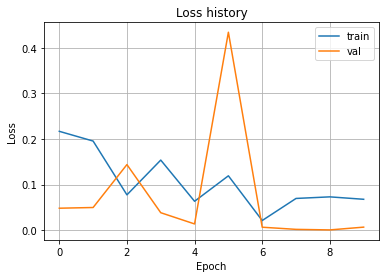

In [36]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history_lstm, label='train')
plt.plot(val_loss_history_lstm, label='val')
plt.legend()
plt.show()

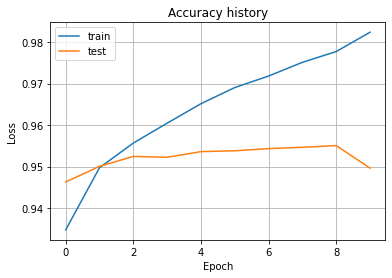

In [37]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_acc_history_lstm, label='train')
plt.plot(val_acc_history_lstm, label='test')
plt.legend()
plt.show()

#### 2.GRU

In [38]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=20, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        # print(x.shape)
        
        gru_out, ht = self.gru(x)
        # gru_out: тензор с выходными фичами с последнего слоя для каждого токена B, L, Hout
        # h_t: тензор с последними скрытыми состояниями по слоям (num_layers, B, Hout)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else: # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
     
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [39]:
gru_net = GRUFixedLen(max_words, 128, 100, use_last=False).to(device)
optimizer = torch.optim.Adam(gru_net.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(gru_net)
print("Parameters:", sum([param.nelement() for param in gru_net.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 385701


In [40]:
#обучение модели
gru_net.train()

train_loss_history_gru = []
val_loss_history_gru = []

train_acc_history_gru = []
val_acc_history_gru = []

train_acc = torchmetrics.Accuracy().to(device)
val_acc = torchmetrics.Accuracy().to(device)

for epoch in range(epochs):  
    gru_net.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_net(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    gru_net.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_dataloader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history_gru.append(loss)
    train_acc_history_gru.append(train_acc.compute().item())
    train_acc.reset()

    
    # выводим статистику на тестовых данных
    for j, data in enumerate(val_dataloader):
        val_labels = data[1].to(device)
        val_outputs = gru_net(data[0].to(device))
        
        # подсчет ошибки на тесте
        val_loss = criterion(val_outputs, val_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        val_acc(val_outputs.squeeze(), val_labels)
    
    val_loss_history_gru.append(val_loss.item())
    val_acc_history_gru.append(val_acc.compute().item())
    print(f'Val loss: {val_loss:.3f}. Val acc: {val_acc.compute().item():.3f}')
    
    val_acc.reset()
    
print('Training is finished!')

Epoch [1/10]. Step [175/175]. Loss: 0.178. Acc: 0.936. Val loss: 0.590. Val acc: 0.946
Epoch [2/10]. Step [175/175]. Loss: 0.098. Acc: 0.949. Val loss: 0.055. Val acc: 0.951
Epoch [3/10]. Step [175/175]. Loss: 0.132. Acc: 0.954. Val loss: 0.140. Val acc: 0.952
Epoch [4/10]. Step [175/175]. Loss: 0.078. Acc: 0.959. Val loss: 0.093. Val acc: 0.951
Epoch [5/10]. Step [175/175]. Loss: 0.080. Acc: 0.963. Val loss: 0.013. Val acc: 0.952
Epoch [6/10]. Step [175/175]. Loss: 0.073. Acc: 0.967. Val loss: 0.330. Val acc: 0.952
Epoch [7/10]. Step [175/175]. Loss: 0.046. Acc: 0.969. Val loss: 0.009. Val acc: 0.954
Epoch [8/10]. Step [175/175]. Loss: 0.055. Acc: 0.974. Val loss: 0.002. Val acc: 0.948
Epoch [9/10]. Step [175/175]. Loss: 0.088. Acc: 0.976. Val loss: 0.151. Val acc: 0.947
Epoch [10/10]. Step [175/175]. Loss: 0.030. Acc: 0.978. Val loss: 0.005. Val acc: 0.951
Training is finished!


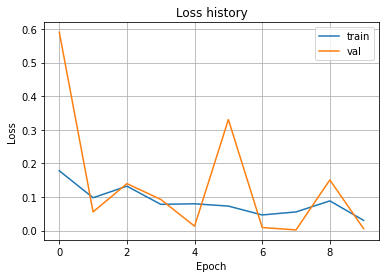

In [41]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history_gru, label='train')
plt.plot(val_loss_history_gru, label='val')
plt.legend()
plt.show()

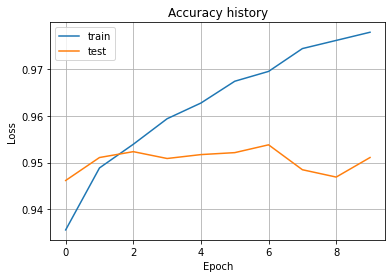

In [42]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_acc_history_gru, label='train')
plt.plot(val_acc_history_gru, label='test')
plt.legend()
plt.show()

In [43]:
round(float(train_acc_history_lstm[-1]), 3)

0.982

In [44]:
# сводная таблица метрик моделей
metrics_result = pd.DataFrame({'Acc_train': [round(float(train_acc_history_lstm[-1]), 3), round(float(train_acc_history_gru[-1]), 3)],
                                'Acc_val': [round(float(val_acc_history_lstm[-1]), 3), round(float(val_acc_history_gru[-1]), 3)]},
                              index =['LSTM', 'GRU'])

metrics_result

,Acc_train,Acc_val
LSTM,0.982,0.950
GRU,0.978,0.951


**Выводы:**  
- увеличение количества эпох не повлияло на метрику, т.к. ее рост не монотонный
- уменьшение batch_size и количества слов в последовательности (max_len) поспособствовало увеличению метрики
- oversampling классов привел к ухудшнеию результата, в итоговой версии отказалась от него
- значения метрики при выборе последнего или среднего значения выходного тензора после рекуррентного слоя практически не отличаются
- увеличение количества рекуррентых слоев не оказало влияния на метрику, но время обучения существенно увеличилось
- увеличение количества нейронов в скрытом слое (hidden_dim) положительно повлияло на метрику
- увеличение размера embedding-a привело к усилению переобучения
- сети LSTM и GRU показали себя примерно одинаково успешно